# Activity recognition using accelerometer data
## Analysis and preprocessing

In [23]:
import os
from os.path import join

import pandas as pd

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import seaborn as sns

DATA_PATH = join('.', 'data')


def read_dataset():
    dfs = []

    for label in os.listdir(DATA_PATH):
        label_path = join(DATA_PATH, label)

        for sample in os.listdir(label_path):
            temp = pd.read_csv(join(label_path, sample))
            temp.loc[:, 'label'] = label
            dfs.append(temp)

    df = pd.concat(dfs, keys=range(0, len(dfs)), names=['sample', 'index'])
    df = df.set_index(keys=[df['label'], df.index])
    df = df.sort_index()
    df = df.sort_index(level=1)
    return df


In [24]:
df = read_dataset()

Text(0.5, 1.05, 'Pairplot for the whole dataset')

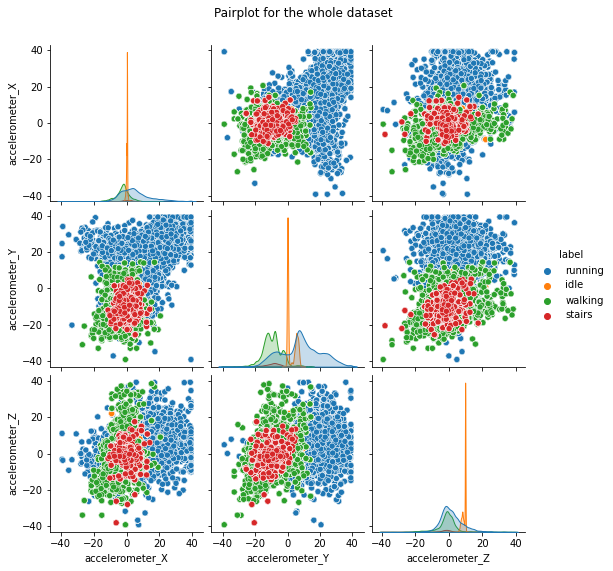

In [25]:
p = sns.pairplot(df, hue='label')
p.fig.suptitle("Pairplot for the whole dataset", y=1.05)

In the visulization we can see that classes have pretty distinguishable distribution in at least one of the dimension, except for 'walking' and 'stairs' pair. Let's look at them closer:

Text(0.5, 1.05, "Pairplot for 'walking' and 'stairs' classes")

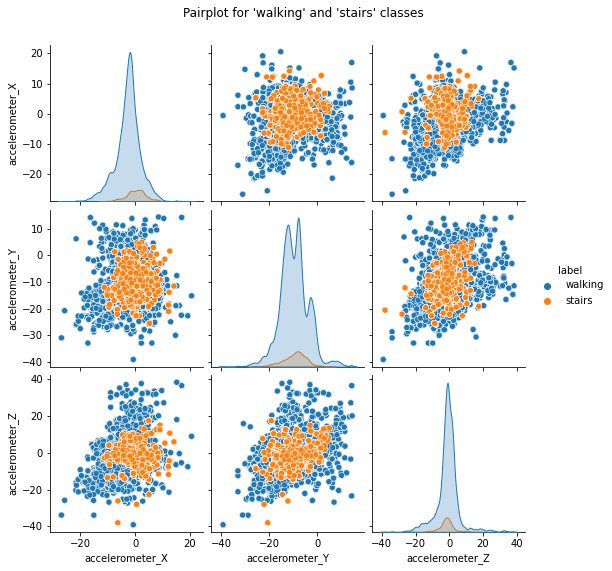

In [26]:
p = sns.pairplot(df[df['label'].isin({'walking', 'stairs'})], hue='label')
p.fig.suptitle("Pairplot for 'walking' and 'stairs' classes", y=1.05)

It's clear 'walking' and 'stairs' might be confused, but 'stairs' has lower variance than 'walking'

In [27]:
df.describe()

,accelerometer_X,accelerometer_Y,accelerometer_Z
count,193860.000000,193860.000000,193860.000000
mean,1.923550,1.598343,1.804896
std,8.404867,12.474041,7.191590
min,-39.188293,-39.188293,-39.188293
25%,-2.494758,-8.327033,-2.494758
50%,0.248997,-0.009577,0.905008
75%,4.668694,8.671799,7.187394
max,39.188293,39.188293,39.188293


In [28]:
df[df.isna().any(axis=1)]

,,,accelerometer_X,accelerometer_Y,accelerometer_Z,label
label,sample,index,,,,


The dataset is not normalized and there no NaN values. Let's see the distribution of classes and calculate the mean of the each sequence:

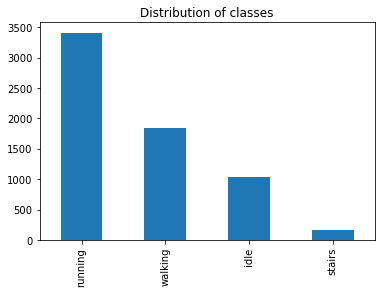

In [29]:
means = df.groupby(level=[0, 1]).mean()
dist = means.index.get_level_values('label').value_counts()
p = dist.plot(kind='bar', title="Distribution of classes")

In [30]:
means

accelerometer_X  accelerometer_Y  accelerometer_Z
label   sample                                                   
idle    3408          -0.060813         6.359798         7.305188
        3409          -0.066878         6.586609         7.192821
        3410           0.267512        -0.009577         9.768503
        3411           0.264320        -0.116677         9.760682
        3412           0.301669        -0.085393         9.757330
...                         ...              ...              ...
walking 6292          -4.603571       -10.256122        -0.684742
        6293          -3.160027        -9.460129        -0.502463
        6294          -4.950730       -10.540074        -1.752396
        6295          -2.324451        -9.542969         0.501186
        6296          -4.589844       -10.383812        -0.041340

[6462 rows x 3 columns]

Text(0.5, 1.05, 'Pairplot for the mean of samples')

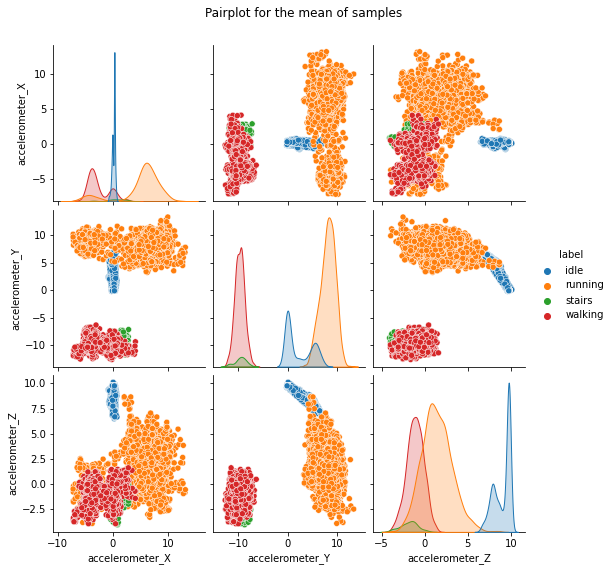

In [31]:
p = sns.pairplot(means.reset_index().drop('sample', axis=1), hue='label')
p.fig.suptitle("Pairplot for the mean of samples", y=1.05)

As expected the distributions of means look even more similar for 'stair' and 'walking'. Since 'stairs' is the smallest class this might be a problem.

## Baseline model

Let's create a baseline model using only means of features and see how it performs. Let's use Random Forest, since it might not require a lot of hyperpareters tuning and it doesn't require data normalization or scaling. Since the dataset is imbalanced, we'll use stratified k-fold for cross-validation and average of validation metrics from each fold:

              precision    recall  f1-score      support
idle           1.000000  1.000000  1.000000   207.800000
running        1.000000  1.000000  1.000000   681.600000
stairs         0.848147  0.539394  0.657555    33.000000
walking        0.960237  0.991351  0.975537   370.000000
accuracy       0.985763  0.985763  0.985763     0.985763
weighted avg   0.984739  0.985763  0.984253  1292.400000
macro avg      0.952096  0.882686  0.908273  1292.400000


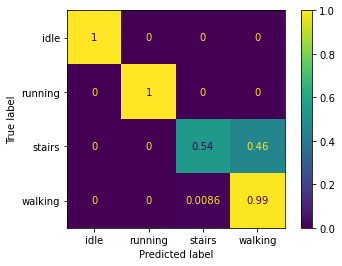

In [32]:
y = means.index.get_level_values('label')
labels = y.unique().tolist()


def train_stratified_cross(X, y, classifier):
    reps = []
    conf_matrices = []
    classifiers = []
    importances = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        clf = classifier(random_state=42)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        classifiers.append(clf)

        preds = clf.predict(X_test)
        report = classification_report(y_test, preds, output_dict=True)
        df_rep = pd.DataFrame(report).transpose()

        reps.append(df_rep)
        importances.append(clf.feature_importances_)
        cm = confusion_matrix(y_test, preds, normalize='true')
        conf_matrices.append(cm)

    reports = pd.concat(reps)
    conf_matrix = np.mean(conf_matrices, axis=0)
    importance = np.mean(importances, axis=0)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=clf.classes_)
    disp.plot()
    print(reports.groupby(reports.index).mean(
    ).loc[labels+['accuracy', 'weighted avg', 'macro avg'], :])
    return classifiers, importance


classifiers, importance = train_stratified_cross(
    means.to_numpy(), y, RandomForestClassifier)


The baseline model shows pretty decent results, except for the 'stairs' class which is confused with 'walking' as expected.

## Improving the baseline

We saw that 'walking' and 'stairs' might have similar means, but different variances. Let's generate additional features from the sequences. Standard deviation might be usefull here, and also min, max, median, 25 percentile, 75 percentile of each feature in each sequence:

In [33]:
def percentile(q):
    return lambda x: np.percentile(x, q)


aggs = df.groupby(level=[0, 1]).agg(['mean', 'std',
                                     'min', 'max',
                                     'median', percentile(25),
                                     percentile(75)]
                                    ).rename(columns={'<lambda_0>': 'per_25',
                                                      '<lambda_1>': 'per_75'})


In [34]:
aggs

accelerometer_X                                           \
                          mean       std        min       max    median   
label   sample                                                            
idle    3408         -0.060813  0.336230  -0.885855  0.828394 -0.043095   
        3409         -0.066878  0.367580  -0.885855  0.828394 -0.057461   
        3410          0.267512  0.071143   0.162806  0.440533  0.260968   
        3411          0.264320  0.216155  -0.373495  1.010353  0.258574   
        3412          0.301669  0.164862   0.172383  1.010353  0.265756   
...                        ...       ...        ...       ...       ...   
walking 6292         -4.603571  4.797322 -14.456190  1.853112 -3.596091   
        6293         -3.160027  3.234947  -9.514558  3.634398 -2.978387   
        6294         -4.950730  4.055511 -12.775460  1.465252 -4.604050   
        6295         -2.324451  3.869489  -9.892841  6.737284 -2.082955   
        6296         -4.589844  4.811267 -14.973337  2.489970 -3.351883   

                                   accelerometer_Y                       ...  \
                  per_25    per_75            mean       std        min  ...   
label   sample                                                           ...   
idle    3408   -0.245406  0.111330        6.359798  0.328943   5.473145  ...   
        3409   -0.259771  0.100556        6.586609  0.386245   5.473145  ...   
        3410    0.237026  0.281319       -0.009577  0.067473  -0.158017  ...   
        3411    0.237026  0.271742       -0.116677  0.143070  -0.828394  ...   
        3412    0.240617  0.290896       -0.085393  0.029733  -0.134075  ...   
...                  ...       ...             ...       ...        ...  ...   
walking 6292   -8.394071 -1.011550      -10.256122  4.941593 -19.895817  ...   
        6293   -5.865794 -1.459266       -9.460129  5.200268 -16.745047  ...   
        6294   -6.846220 -2.053028      -10.540074  4.147447 -20.441694  ...   
        6295   -4.981136  0.328005       -9.542969  4.412433 -17.477673  ...   
        6296   -7.285555 -1.769315      -10.383812  5.101334 -22.471977  ...   

                                               accelerometer_Z             \
                   median     per_25    per_75            mean        std   
label   sample                                                              
idle    3408     6.320693   6.204574  6.552930        7.305188   0.465193   
        3409     6.545748   6.309919  6.861782        7.192821   0.478098   
        3410    -0.011971  -0.038307  0.013168        9.768503   0.021247   
        3411    -0.090980  -0.105345 -0.071826        9.760682   0.035156   
        3412    -0.088585  -0.104148 -0.073023        9.757330   0.033675   
...                   ...        ...       ...             ...        ...   
walking 6292   -11.820174 -13.923480 -7.498640       -0.684742  10.252445   
        6293   -10.354923 -12.522873 -7.631518       -0.502463   6.676202   
        6294   -11.149797 -13.357252 -7.518990       -1.752396   5.439466   
        6295   -10.591948 -12.476185 -6.914455        0.501186   5.817856   
        6296   -10.879252 -13.830106 -7.304709       -0.041340   9.671621   

                                                                    
                      min        max    median    per_25    per_75  
label   sample                                                      
idle    3408     6.042965   8.216900  7.352593  7.067684  7.601591  
        3409     6.416461   8.183381  7.137116  6.810307  7.563283  
        3410     9.715671   9.811439  9.768343  9.759963  9.776723  
        3411     9.610326   9.811439  9.763555  9.758766  9.777920  
        3412     9.610326   9.787497  9.763555  9.758766  9.777920  
...                   ...        ...       ...       ...       ...  
walking 6292   -15.691598  37.138855 -1.175553 -2.476801  0.940921  
        6293   -11.453861  24.109612 -1.302446 -2.980781  0.921767  
     

              precision    recall  f1-score      support
idle           1.000000  1.000000  1.000000   207.800000
running        1.000000  1.000000  1.000000   681.600000
stairs         0.994118  0.957576  0.974991    33.000000
walking        0.996241  0.999459  0.997844   370.000000
accuracy       0.998762  0.998762  0.998762     0.998762
weighted avg   0.998774  0.998762  0.998744  1292.400000
macro avg      0.997590  0.989259  0.993209  1292.400000


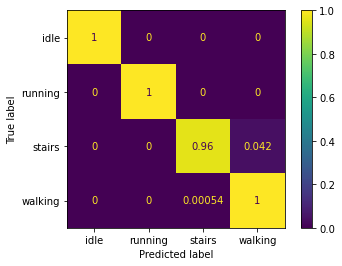

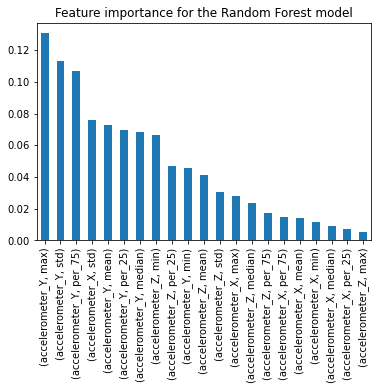

In [35]:
def plot_importances(agg_importance, aggs):
    forest_importances = pd.Series(agg_importance, index=aggs.columns)
    forest_importances = forest_importances.sort_values(ascending=False)
    plt.figure()
    forest_importances.plot.bar(
        title='Feature importance for the Random Forest model')


def visualize_train(aggs, clf):
    y = aggs.index.get_level_values('label')
    _, agg_importance = train_stratified_cross(aggs.to_numpy(), y, clf)
    plot_importances(agg_importance, aggs)


visualize_train(aggs, RandomForestClassifier)


The result for the 'stairs' class improved dramatically! Let's simplify the model by removing some features. Since each sequence length is only 30, percentile features might not be that usefull in such small distributions. Let's remove all the percentile features:

In [36]:
aggs_simpler = aggs.drop(columns=['per_25', 'per_75'], level=1)
aggs_simpler.shape

(6462, 15)

              precision    recall  f1-score      support
idle           1.000000  1.000000  1.000000   207.800000
running        1.000000  1.000000  1.000000   681.600000
stairs         1.000000  0.969697  0.984423    33.000000
walking        0.997310  1.000000  0.998652   370.000000
accuracy       0.999226  0.999226  0.999226     0.999226
weighted avg   0.999230  0.999226  0.999216  1292.400000
macro avg      0.999328  0.992424  0.995769  1292.400000


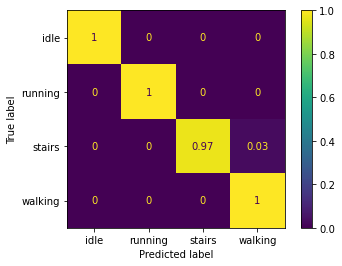

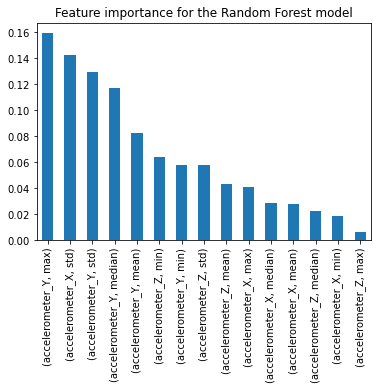

In [37]:
visualize_train(aggs_simpler, RandomForestClassifier)

The result has improved for the 'stairs' class as well as for F1 average and F1 macro score! As we see from the feature importance visualization mean and median feature might be interchangable. They tend to have similar importance, but median seems more important. Let's remove all the mean features:

In [38]:
aggs_simpler_2 = aggs_simpler.drop(columns=['mean'], level=1)
aggs_simpler_2.shape

(6462, 12)

              precision    recall  f1-score      support
idle           1.000000  1.000000  1.000000   207.800000
running        1.000000  1.000000  1.000000   681.600000
stairs         1.000000  0.975758  0.987596    33.000000
walking        0.997847  1.000000  0.998921   370.000000
accuracy       0.999381  0.999381  0.999381     0.999381
weighted avg   0.999383  0.999381  0.999374  1292.400000
macro avg      0.999462  0.993939  0.996629  1292.400000


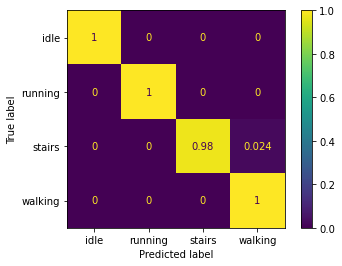

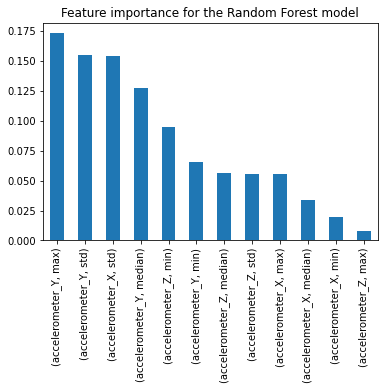

In [39]:
visualize_train(aggs_simpler_2, RandomForestClassifier)

The result has improved even further!

## Results and ideas for further improvements

The best model showed great results with <b>weighted F1 score = 0.999374</b> and <b>macro F1 score = 0.996629</b> with the average of the stratified cross-validation. There is probably room for improvement for the <b>recall = 0.975758</b> of the class 'stairs'.

If recall for 'stairs' class needs to be improved, it's worth trying oversampling to compensate for the class imbalance.

We gradually reduced the number of features of the model, which made it generalize better and which made it simpler. To make model even simpler it's possible to tune hyperharameters. Probably, it's possible to reduce the number of trees or the maximum depth with the performance preservation. We can also use Grid Search or Randomized Search to find better hyperparameters.

Some outlier analysis and removal might also be useful for the improvement of the model generalization, but that also depends on the usage of the model in the real world.

In our model, statistics of the sequences were used as features. Probably, it's worth trying some sequence based models. It requires more preprocessing, since the sequences are too long (with length 30) for the size of the dataset (and because it's unbalanced). So, for the sequence based models the length of the sequences should probably be reduced by aggregating functions or by splitting the sequences into the smaller ones.